In [112]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Transformation utilties

Distgen provides a set of basic transformation utilities that can be applied the particle coordinates of a beam object.  Here the basic examples are discused: the transformation functions are defined as well as how to use them from the standard Distgen input structure.  Note the these transformation operations do not in general commute.

The primary example used is that of a uniform radial distribution, as seen below.

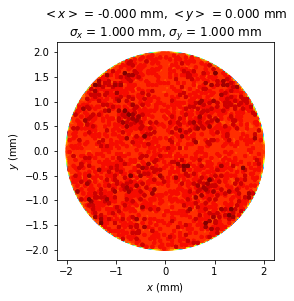

In [1]:
units = {'x':'mm','y':'mm','r':'mm','px':'keV/c','py':'keV/c','t':'ps','q':'pC'}

# Basic Beer can example using a json file:
from distgen.generator import Generator
from distgen.plot import plot_2d
from distgen.physical_constants import unit_registry as unit
from matplotlib import pyplot as plt

# The distgen reader assumes the input file is json formatted.  If not it, it defaults to parsing the file as an ascii txt file.
filename = "data/beer.can.in.json"
gen=Generator(filename,verbose=0)
beam = gen.beam()
plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",title_on=True);

# Translations

Translations of the coordinate $u$ are defined by: $u\rightarrow u + \Delta u$.

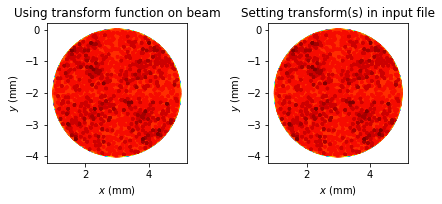

In [184]:
# Translations: a translation of a single coordinate are handled by transforms.translate
from distgen.transforms import translate

filename = "data/beer.can.in.json"
gen=Generator(filename,verbose=0)
beam1=gen.beam()

translate(beam1,'x',+3*unit('mm'))
translate(beam1,'y',-2*unit('mm'))

# Translations can be added to the distgen input parameters by adding them to the transforms key:
gen.input['transforms']={
    '+3mm_xshift':{'type':'translate', 
                  'variables':'x', 
                  'params':{'delta': {'value':3, 'units':'mm',}}
                  },
    '-2mm_yshift':{'type':'translate', 
                  'variables':'y', 
                  'params':{'delta': {'value':-2, 'units':'mm',}}
                  },
}

beam2 = gen.beam()

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)
plot_2d(beam1,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[0]);
ax[0].set_title('Using transform function on beam')

plot_2d(beam2,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[1]);
ax[1].set_title('Setting transform(s) in input file');

# Scaling

Basic scaling is handled using transforms.scale.  To scale the $x$ coordinate of the beam by $\alpha$ use:

scale(beam,'x',$\alpha$) 

where $\alpha$ is a dimensionless quantity or float.  Note that if the $<x>\neq0$ then 
$<x>\rightarrow\alpha<x>$.  It is possible to fix the average value under scaling using:

scale(beam, 'x', $\alpha$, fix_average='True') 


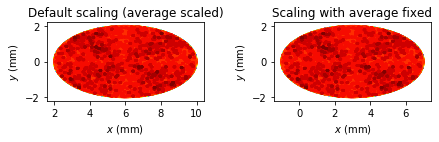

In [193]:
from distgen.transforms import scale
gen=Generator(filename,verbose=0)
beam1 = gen.beam()
translate(beam1,'x',3*unit('mm'))
scale(beam1,'x',2)

beam2 = gen.beam()
translate(beam2,'x',3*unit('mm'))
scale(beam2,'x',2,fix_average=True)

fig, ax = plt.subplots(1, 2, constrained_layout=True)
plot_2d(beam1,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[0]);
ax[0].set_title('Default scaling (average scaled)')

plot_2d(beam2,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[1]);
ax[1].set_title('Scaling with average fixed');


# Shift and Scale a single coordinate

It is possible to combine a translation with a scaling operation to shift and rescale a coordinate
to have a new standard deviation while keeping the form of the underlying coordinate distribution unchanged. This is accomplished using transforms.set_avg_and_std(...)

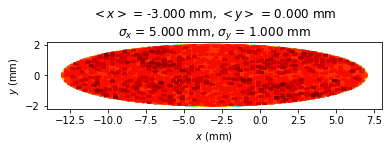

In [196]:
from distgen.transforms import set_avg_and_std
gen=Generator(filename,verbose=0)
beam = gen.beam()
set_avg_and_std(beam,'x',-3*unit('mm'),5*unit('mm'))
plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",title_on=True);

# Rotating coordinates

Rotation between two coordinates is accomplished using transforms.rotate2d.  In addition to the beam 
object, the user must specify the variables to rotate.  This can be done in a string of the form 'var1:var2' or as a list of strs ['var1','var2'].  The variables supplied must have the same type of units.  The user must also specify an angle in radians or degrees to rotate by. 

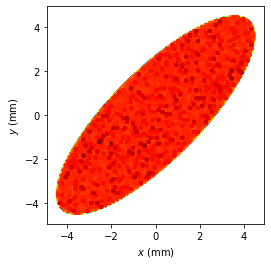

In [181]:
from distgen.transforms import rotate2d
gen=Generator(filename,verbose=0)
beam = gen.beam()
scale(beam,'x',3.0)

rotate2d(beam, 'x:y', 45*unit('deg'))

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");


Note, the default behavior is to rotate around the coordinate origins (not the coordinate averages):

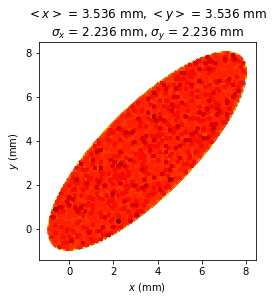

In [8]:
gen=Generator(filename,verbose=0)
beam = gen.beam()
scale(beam,'x',3.0)
translate(beam,'x',5*unit('mm'))
rotate2d(beam, 'x:y', 45*unit('deg'))

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

The rotation can be performed about a different origin by setting the keyword arguement 'origin'.  Often it is desirable to set the origin of rotation to be the coordinate centroids. This is done by setting origin='centroid':

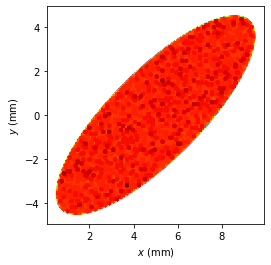

In [199]:
gen=Generator(filename,verbose=0)
beam = gen.beam()
scale(beam,'x',3.0)
translate(beam,'x',5*unit('mm'))
rotate2d(beam, 'x:y', 45*unit('deg'), origin='centroid')

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

# Sheer

The sheer operation allows one to apply a sheer in a 2D subspace according of the form:

$v\rightarrow v + \alpha u$

This can be useful in a variety of cases such as drifting particles.

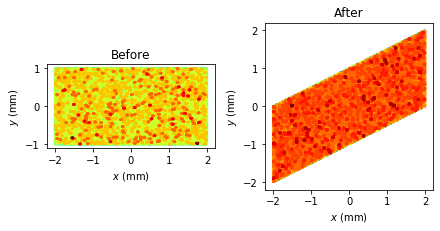

In [211]:
gen=Generator('data/x.y.uniform.in.json',verbose=0)
beam1=gen.beam()

beam2=gen.beam()
sheer(beam2,'x:y',0.5)

fig, ax = plt.subplots(1, 2, constrained_layout=True)
plot_2d(beam1,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[0]);
ax[0].set_title('Before')

plot_2d(beam2,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[1]);
ax[1].set_title('After');

Magnetizing a cylindrical beam provides a more physically relevant application of the sheer function.  Here the magnetization 
$\mathcal{L}$
is added to the particle momentum in the form
$p_x\rightarrow p_x + \frac{\mathcal{L}}{\sigma_{x,y}^2}y$
and $p_y\rightarrow p_y - \frac{\mathcal{L}}{\sigma_{x,y}^2}x$.  This results in a transverse emittance of
$\sqrt{\epsilon_{n,x,uncor}^2 + \mathcal{L}^2}$.  Note that using the definitions of cylindrical variables it is possible to show this is equivalent to a sheer of 
$p_{\theta}\rightarrow p_{\theta}-\frac{\mathcal{L}}{\sigma_{x,y}^2}r$. 

% error in magnetization  1.2103734493580161e-05 dimensionless


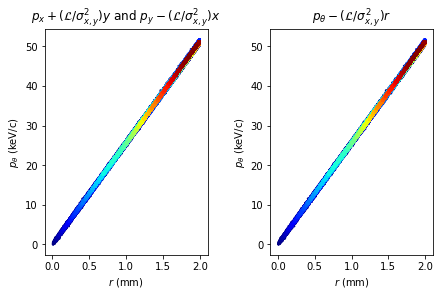

In [220]:
from distgen.physical_constants import MC2
import numpy as np
from distgen.transforms import sheer

gen = Generator(filename,verbose=0)
beam = gen.beam()

xemitt_uncorrelated = beam.emitt('x')

Lmag = -50*unit('micrometers')*MC2.magnitude*unit("eV/c")
sheer_coefficient = Lmag/beam.std('y')/beam.std('y')
sheer(beam,'y:px',sheer_coefficient)
sheer(beam,'x:py',-sheer_coefficient)

xemitt = beam.emitt('x')
print('% error in magnetization ', 100*(xemitt - np.sqrt(xemitt_uncorrelated**2 + Lmag**2) )/xemitt )

gen = Generator(filename,verbose=0)
beam2 = gen.beam()
sheer(beam2,'r:ptheta',-sheer_coefficient)

fig, ax = plt.subplots(1, 2, sharex='col', constrained_layout=True)
plot_2d(beam,1,"r",units["r"],"ptheta",units["px"],'scatter_hist2d',nbins=100,ax=ax[0]);
ax[0].set_title('$p_x+(\mathcal{L}/\sigma_{x,y}^2)y$ and $p_y-(\mathcal{L}/\sigma_{x,y}^2)x$')

plot_2d(beam2,1,"r",units["r"],"ptheta",units["px"],'scatter_hist2d',nbins=100,ax=ax[1]);
ax[1].set_title('$p_{\\theta}-(\mathcal{L}/\sigma_{x,y}^2)r$');

For symplicity, a magnetization function has been defined to perform the above transform given the magnetization $\mathcal{L}$.  Currently this assumes a cylindrically symmetric bunch.

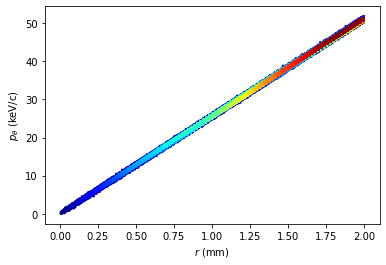

In [229]:
from distgen.physical_constants import MC2
from distgen.transforms import magnetize

Lmag = -50*unit('micrometers')*MC2.magnitude*unit("eV/c")
gen = Generator(filename,verbose=0)
beam = gen.beam()
magnetize(beam,'r:ptheta',Lmag)

plot_2d(beam,1,"r",units["r"],"ptheta",units["px"],'scatter_hist2d',nbins=100);

# Adding Transformations to a Distgen input file

A set of transformations can be applied to a beam when it is created by adding the transformation descriptions to the nested input dictionary structure.  All inputs to the transform function other than the variable names should go in the 'params' dictionary in the transform definition.  Physical quantities with units should be dictionaries with a 'value' and 'units' key/value pair supplied.  Transformations are applied in the order they are input in the transforms dictionary.  In the example below, two transforms are include: scaling a round beam so that it is oval, and then rotated the beam by 45 deg.

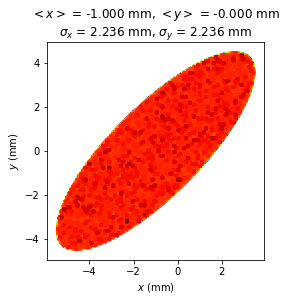

In [230]:
gen = Generator(filename, verbose=0) 

gen.input['transforms']={
    '3mm_scale':{'type':'scale', 
                         'variables':'x', 
                         'params':{'scale': {'value':3, 'units':'dimensionless',}
                                  }
                },
    'rot45deg': {'type': 'rotate2d', 
                        'variables': 'x:y', 
                        'params': {'angle': {'value': 45, 'units': 'deg'}}
                },
    'xshift':   {'type': 'translate', 
                        'variables': 'x', 
                        'params': {'delta': {'value': -1, 'units': 'mm'}}
                },
}

beam = gen.beam()

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",title_on=True);